Enter number of clusters: 5
0.22839497757358454
0.24027490670890495


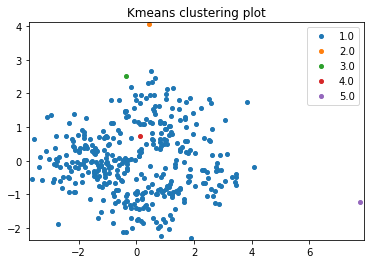

In [15]:
#hierarchical Clustering with MIN distance matrix updation method.
import numpy as np
import sys
from scipy.spatial import distance
from sklearn.decomposition import PCA
import pandas as pd
import matplotlib.pyplot as plt
from scipy.spatial.distance import pdist, squareform


np.set_printoptions(suppress=True) #prevent numpy exponential 

def read_data(file):
    gene_data = open(file)
    gene_seq = gene_data.readlines()
    all_genes_list = []
    for line in gene_seq:
        gene = line.strip().split("\t")
        all_genes_list.append(gene)
    return np.asarray(all_genes_list, dtype = float)

def dist_matrix(data):
    distance_matrix = np.zeros([data.shape[0],data.shape[0]])
    distance_matrix = squareform(pdist(data, 'euclidean'))
    return distance_matrix

def perform_HAC(data, distance_matrix, cluster_count,clusters,iteration_count):
    #print("it ",iteration_count , " clus cnt ",cluster_count)
#     if((iteration_count + cluster_count) == len(data)):
#         return clusters
    if(len(clusters) == cluster_count):
        return clusters
    
    minimum_dist = (distance_matrix[distance_matrix > 0]).min()
    closest_points = np.where(distance_matrix == minimum_dist)
    p1 = min(closest_points[1][0], closest_points[1][1])
    p2 = max(closest_points[1][0], closest_points[1][1])
    
    for g in range(0,len(data)):
        min_dis = min(distance_matrix[p1][g], distance_matrix[p2][g])
        distance_matrix[p1][g] = min_dis
        distance_matrix[g][p1] = min_dis
        distance_matrix[p2][g] = -1
        distance_matrix[g][p2] = -1
#     distance_matrix[p1][p2] = -1
#     distance_matrix[p2][p1] = -1
    for p2g in range(0,len(clusters[p2+1])):
        clusters[p1+1].append(clusters[p2+1][p2g])
    clusters.pop(p2+1)
    return perform_HAC(data, distance_matrix, cluster_count, clusters, iteration_count+1)

def compute_similarity_terms(gene_data, cluster_ids):
    m11 = 0
    m01 = 0
    m10 = 0
    m00 = 0
    for g1 in range(0,gene_data.shape[0]):
        g1_ground_truth = gene_data[g1][1]
        g1_cluster_id = cluster_ids[g1]
        #print(g1_ground_truth, " : ", g1_cluster_id)
        for g2 in range(0, gene_data.shape[0]):
            g2_ground_truth = gene_data[g2][1]
            g2_cluster_id = cluster_ids[g2]
            if(g1_ground_truth == g2_ground_truth and g1_cluster_id == g2_cluster_id):
                m11 += 1
            elif(g1_ground_truth == g2_ground_truth and g1_cluster_id != g2_cluster_id):
                m10 += 1
            elif(g1_ground_truth != g2_ground_truth and g1_cluster_id == g2_cluster_id):
                m01 += 1
            elif(g1_ground_truth != g2_ground_truth and g1_cluster_id != g2_cluster_id):
                m00 += 1
    return m11, m01, m10, m00

def plot_PCA(gene_features,cluster_ids):
    pca = PCA(n_components = 2)
    data_reduced = pca.fit_transform(gene_features)

    # Appending disease column to dimensionally reduced data
    cluster_ids = cluster_ids.reshape(gene_features.shape[0],1)
    newData = np.hstack((data_reduced,cluster_ids))

    #Plotting the 2D data
    newDf = pd.DataFrame(data = newData)
    groups = newDf.groupby(newDf.columns[newData.shape[1]-1])

    fig, ax = plt.subplots()
    plt.title('Kmeans clustering plot')
    ax.margins(0.01)
    for name, group in groups:
        ax.plot(group[0], group[1], marker='o', linestyle='', ms=4, label=name)
    ax.legend(numpoints=1, loc='best')

    plt.show()

gene_data = read_data("cho.txt")
gene_features = gene_data[:,2:]
#print(gene_features)
distance_matrix = dist_matrix(gene_features)
cluster_count = int(input("Enter number of clusters: "))
clusters = dict()
for i in range(1,len(gene_data)+1):
    clusters[i] = [i-1]
clusters = perform_HAC(gene_features, distance_matrix, cluster_count,clusters,0)
cluster_ids = np.zeros(gene_data.shape[0])
#print(clusters)
#print(len(clusters))
id = 1
leng = 0
for i in clusters:
    for j in clusters[i]:
        cluster_ids[j] = id
    id += 1
#print(len(clusters))
#print(clusters)
#print(cluster_ids)

m11, m01, m10, m00 = compute_similarity_terms(gene_data, cluster_ids)
jacard_coef = float(m11)/float(m11+m10+m01)
print(jacard_coef)

rand_index = float(m11+m00)/float(m11+m10+m01+m00)
print(rand_index)

#Plot PCA for gene_features data set
plot_PCA(gene_features,cluster_ids)
